## Data Exploration

In [ ]:
# Extension reloader to import a function again when re-running cell 
%load_ext autoreload
%autoreload 2

In [ ]:
from datetime import datetime
program_start_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
print('Started: '+ program_start_time)

### Load configuration

In [ ]:
"""
Loads common configuration parameters
"""
import utils.configuration_manager as configuration_manager
from pathlib import PurePath
from os import getcwd

config_path = PurePath(getcwd(),'config.ini')
config = configuration_manager.Config(config_path)

# Assumes parquet directory as input
input_path = config.input_path
print('Input path: '+ input_path)

# For result storage
output_directory = config.output_directory
print('Output path: ' + output_directory)

### Start local Dask Client

In [ ]:
from dask.distributed import Client, LocalCluster
try:
    if client:
        print('Restarting client')
        client.restart()
except:
#     cluster = LocalCluster(dashboard_address=':20100', memory_limit='4G')
    cluster = LocalCluster(dashboard_address=':20100')
    print('Setting new client')
    client = Client(cluster)
    print(client)
client

### Dask dataframe loader

In [ ]:
import dask.dataframe as dd
import fastparquet

In [ ]:
ddf = dd.read_parquet(input_path)

In [ ]:
ddf.head()

In [ ]:
print(ddf.dtypes)

## Basic Data Statistics

In [9]:
print(ddf.describe().compute())

       passenger_count  trip_distance   fare_amount         extra  \
count     1.122346e+08   1.122346e+08  1.122346e+08  1.122346e+08   
mean      1.595515e+00   2.929440e+00  1.302615e+01  3.310082e-01   
std       1.241769e+00   1.833739e+01  1.470310e+02  4.659486e-01   
min       0.000000e+00   0.000000e+00 -8.000000e+02 -8.000000e+01   
25%       1.000000e+00   1.060000e+00  7.000000e+00  0.000000e+00   
50%       1.000000e+00   1.800000e+00  1.050000e+01  5.000000e-01   
75%       2.000000e+00   3.580000e+00  1.750000e+01  1.000000e+00   
max       1.920000e+02   1.894838e+05  9.070702e+05  9.664000e+01   

            mta_tax    tip_amount  tolls_amount  improvement_surcharge  \
count  1.122346e+08  1.122346e+08  1.122346e+08           1.122346e+08   
mean   4.971520e-01  1.872474e+00  3.450687e-01           2.996225e-01   
std    5.218331e-02  2.607947e+00  1.781228e+00           6.046083e-01   
min   -5.000000e-01 -3.224200e+02 -5.250000e+01          -3.000000e-01   
25%    5

### Tip by location

In [10]:
pu_location = 'PULocationID'
do_location = 'DOLocationID'
tip = 'tip_amount'

In [11]:
tip_by_region = ddf.groupby(pu_location)[tip].mean()

In [12]:
tip_by_region.compute()

distributed.nanny - WARNING - Restarting worker


PULocationID
1      10.791346
10      6.435483
100     1.481584
101     1.403136
102     1.161811
         ...    
109     6.477368
110     1.185000
99      1.015000
199     3.179474
104     0.000000
Name: tip_amount, Length: 264, dtype: float64

### Tips by day of the week

In [13]:
# Using picking time as the timestamp
ts = 'tpep_pickup_datetime'

In [14]:
%time day_of_week_tips = ddf.groupby([ddf[ts].dt.dayofweek])[tip].mean().compute()

distributed.nanny - WARNING - Restarting worker


CPU times: user 4.53 s, sys: 559 ms, total: 5.09 s
Wall time: 57.9 s


In [16]:
days_dict = {'Monday':0, 
             'Tuesday':1, 
             'Wednesday':2, 
             'Thursday':3, 
             'Friday':4, 
             'Saturday': 5, 
             'Sunday':6}

In [17]:
index_map = {y:x for x, y in days_dict.items()}
day_of_week_tips.index = day_of_week_tips.index.map(index_map)

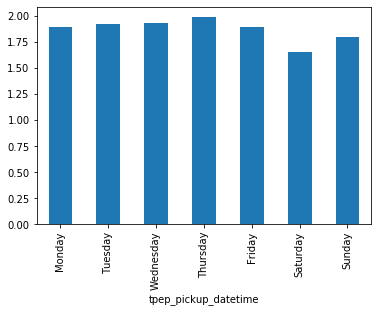

In [18]:
# import matplotlib.pyplot as plt
day_of_week_tips.plot.bar(x='Day of the week', y='Tip mean')

### Seasonal / trends

Let's look at tiping behavior over the course of the year, averaging result by day

In [19]:
%time day_mean_tips = ddf.groupby([ddf[ts].dt.date])[tip].mean().compute()

distributed.nanny - WARNING - Restarting worker


CPU times: user 5.3 s, sys: 483 ms, total: 5.78 s
Wall time: 1min 5s


In [20]:
print(day_mean_tips)

tpep_pickup_datetime
2009-01-01    1.394906
2018-11-07    2.069009
2018-12-01    1.707368
2018-12-02    1.817992
2018-12-03    2.030543
                ...   
2018-11-03    1.679070
2019-11-20    1.700000
2019-11-21    0.352000
2019-01-04    2.145000
2019-01-26    1.180000
Name: tip_amount, Length: 445, dtype: float64


In [21]:
"""
Cleanup and plot result
"""
day_mean_tips.sort_index(inplace=True)

In [22]:
import pandas as pd
# Transform indices back to datetime objects for filtering
day_mean_tips.index = pd.to_datetime(day_mean_tips.index.to_series())
# results = {index: row for index, row in day_mean_tips.iteritems() if index.year == 2018}

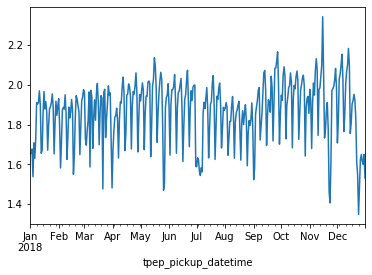

In [23]:
filtered_day_mean_tips = day_mean_tips[day_mean_tips.index.year == 2018]
filtered_day_mean_tips.plot()

#### Aggregate by week

In [24]:
%time weekly_mean_tips = filtered_day_mean_tips.groupby([filtered_day_mean_tips.index.to_series().dt.week]).mean()

CPU times: user 5.48 ms, sys: 3.67 ms, total: 9.15 ms
Wall time: 27.1 ms


(52,)


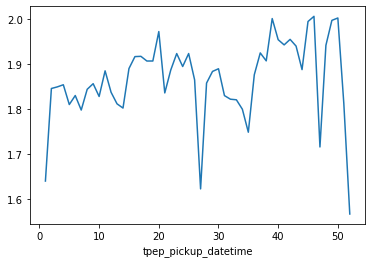

In [25]:
print(weekly_mean_tips.shape)
weekly_mean_tips.plot()

#### Aggregate by month

In [26]:
%time monthly_mean_tips = filtered_day_mean_tips.groupby([filtered_day_mean_tips.index.to_series().dt.month]).mean()

CPU times: user 2.95 ms, sys: 0 ns, total: 2.95 ms
Wall time: 2.64 ms


(12,)


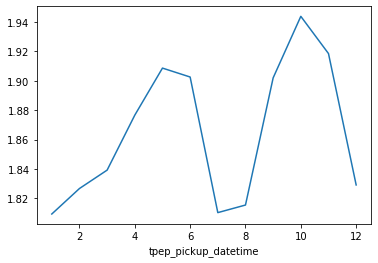

In [27]:
print(monthly_mean_tips.shape)
monthly_mean_tips.plot()

Seems there is some cyclicality to tipping (e.g., a spike in the fall/early winter months). We'd have to look at other things like the variance to gauge how meaninful this trend is. 